In [25]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_similarity as tfsim
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

In [52]:
num_known_classes = 10
classes_per_batch = 10
examples_per_class_per_batch = 8
embedding_size = 256
epochs = 3
learning_rate = 0.002
val_steps = 50
num_neighbors = 5

In [15]:
def conv_block(x, filters, kernel_size=3, strides=1, activation="relu"):
    x = layers.Conv2D(filters, kernel_size, strides=strides, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    return x

In [16]:
def create_model():
    inputs = keras.layers.Input((32, 32, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = layers.MaxPool2D((4, 4))(x)
    x = conv_block(x, 256)
    x = conv_block(x, 256)
    x = layers.GlobalMaxPool2D()(x)

    outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)

    model = tfsim.models.SimilarityModel(inputs, outputs)
    return model

In [17]:
class_list = random.sample(population=range(10), k=num_known_classes)

In [19]:
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cifar10",
    classes_per_batch=min(classes_per_batch, num_known_classes),
    splits="train",
    steps_per_epoch=4000,
    examples_per_class_per_batch=examples_per_class_per_batch,
    class_list=class_list,
)

converting train:   0%|          | 0/50000 [00:00<?, ?it/s]


The initial batch size is 80 (10 classes * 8 examples per class) with 0 augmentations


filtering examples:   0%|          | 0/50000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/50000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/50000 [00:00<?, ?it/s]

In [20]:
val_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cifar10",
    classes_per_batch=classes_per_batch,
    splits="test",
    total_examples_per_class=100,
)

converting test:   0%|          | 0/10000 [00:00<?, ?it/s]


The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmentations


filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
model = create_model()
model.summary()

Model: "similarity_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization_4 (Bat  (None, 30, 30, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 batch_normalization_5 (Bat  (None, 28, 28, 128)       512       
 chNormalization)                               

In [22]:
loss = tfsim.losses.MultiSimilarityLoss()
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss=loss, steps_per_execution=10)


Distance metric automatically set to cosine use the distance arg to override.


In [23]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, validation_steps=val_steps)

Epoch 1/3
4000/4000 [==============================] - 3606s 901ms/step - loss: 1.0048 - val_loss: 0.2941
Warmup complete
Epoch 2/3
4000/4000 [==============================] - 3538s 885ms/step - loss: 0.6040 - val_loss: 0.2726
Epoch 3/3
4000/4000 [==============================] - 3474s 869ms/step - loss: 0.2619 - val_loss: 0.3030


In [26]:
x_index, y_index = val_ds.get_slice(begin=0, size=200)
model.reset_index()
model.index(x_index, y_index, data=x_index)

[Indexing 200 points]
|-Computing embeddings
7/7 [==============================] - 2s 337ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


In [27]:
x_train, y_train = train_ds.get_slice(begin=0, size=1000)
calibration = model.calibrate(
    x_train,
    y_train,
    calibration_metric="f1",
    matcher="match_nearest",
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)

32/32 [==============================] - 2s 76ms/step

Performing NN search



Building NN list:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]


 name        value    distance    precision    recall    binary_accuracy        f1
-------  --------  ----------  -----------  --------  -----------------  --------
optimal  0.942918    0.491271        0.892         1              0.892  0.942918


In [51]:
x_display, y_display = val_ds.get_slice(begin=200, size=10)

tf.config.run_functions_eagerly(False)

nns = model.lookup(x_display, k=num_neighbors)

# Re-enable eager execution
tf.config.run_functions_eagerly(True)

1/1 [==============================] - 0s 54ms/step

Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

In [49]:
labels = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck", "Unknown"
]
class_mapping = {c_id: c_lbl for c_id, c_lbl in enumerate(labels)}

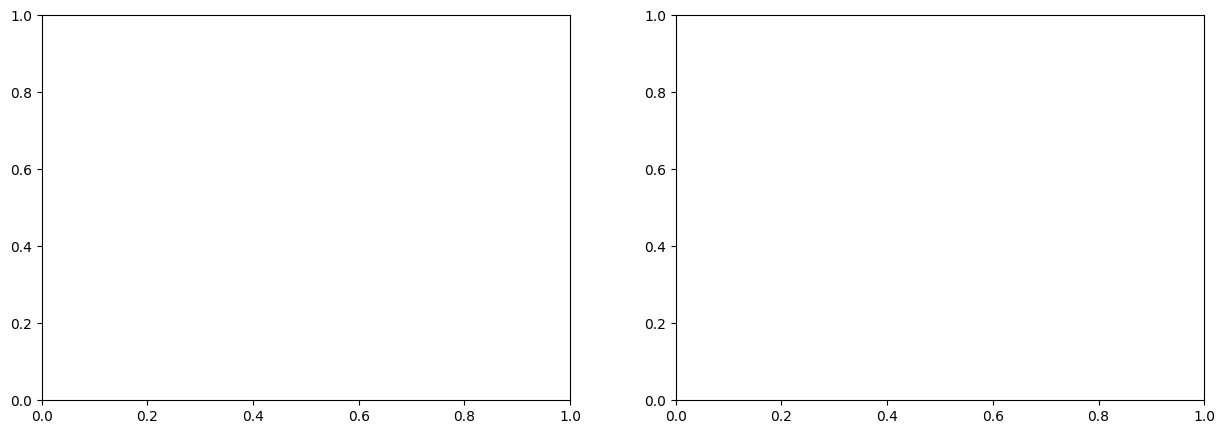

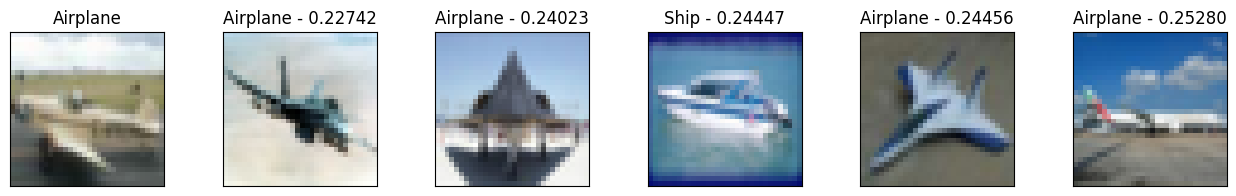

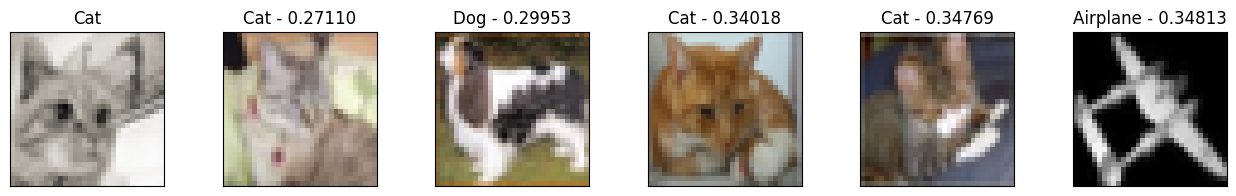

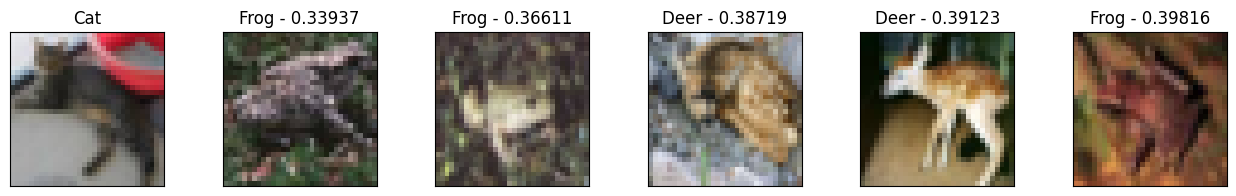

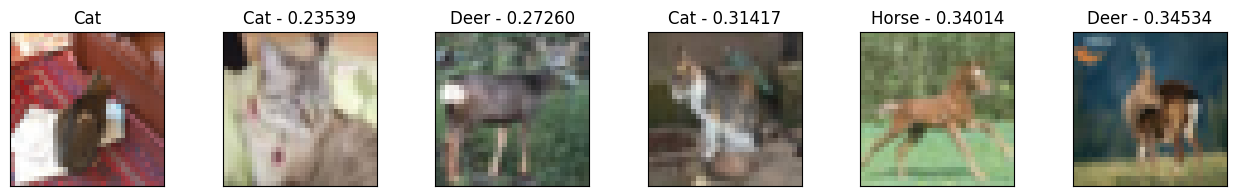

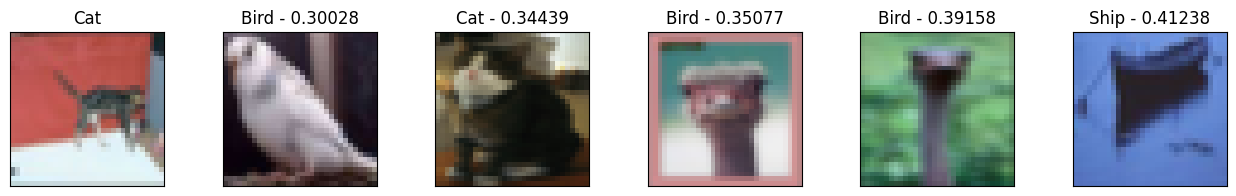

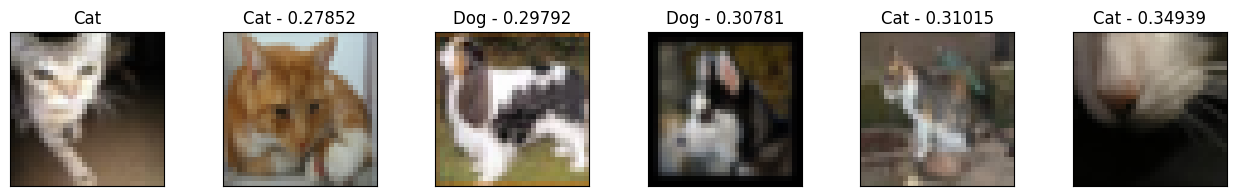

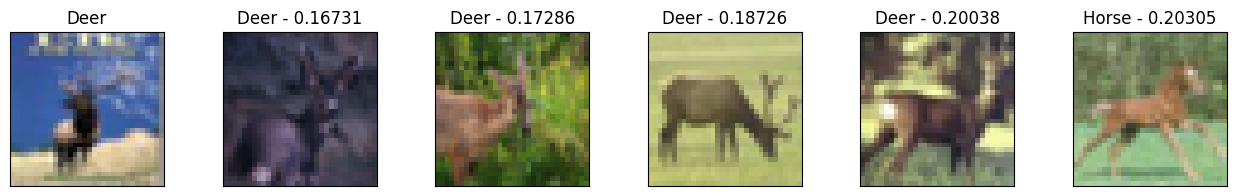

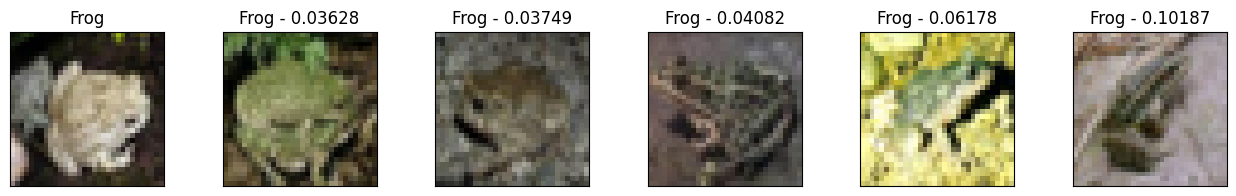

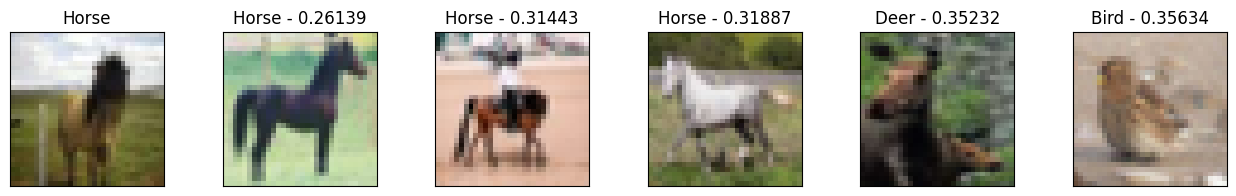

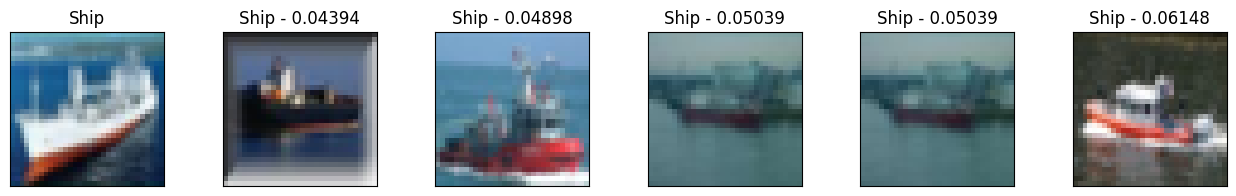

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

class_mapping = {c_id: c_lbl for c_id, c_lbl in enumerate(labels)}

for idx in np.argsort(y_display):
    # Convert TensorFlow tensors to NumPy arrays
    x_display_np = x_display[idx].numpy()
    y_display_np = y_display[idx].numpy()

    # Extract 'embedding' field from the 'Lookup' object
    nns_np = nns[idx]

    tfsim.visualization.viz_neigbors_imgs(
        x_display_np,
        y_display_np,
        nns_np,
        class_mapping=class_mapping,
        fig_size=(16, 2),
    )

x_vals = calibration.thresholds["distance"]
axes[0].plot(x_vals, calibration.thresholds["precision"], label="precision")
axes[0].plot(x_vals, calibration.thresholds["recall"], label="recall")
axes[0].plot(x_vals, calibration.thresholds["f1"], label="f1 score")
axes[0].legend()
axes[0].set_title("Metric evolution as distance increases")
axes[0].set_xlabel("Distance")
axes[0].set_ylim((-0.05, 1.05))

axes[1].plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_ylim((-0.05, 1.05))

plt.show()